<a href="https://colab.research.google.com/github/NilaanL/Koala_Coders/blob/master/intelliHack_koalacoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**



In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix



**Data preparation**

In [2]:

full_data = pd.read_csv('raj.csv')

#Removing unnecessary string values in cells
for row in range(full_data.shape[0]):
    for column in range(full_data.shape[1]):
        if full_data.iat[row,column]=='?':
            full_data.iat[row,column] = np.nan
            
#Converting string values of 3 columns to np.float64
full_data.loc[:,['rc','wc','pcv']] = full_data.loc[:,['rc','wc','pcv']].astype(np.float64)

full_data.drop(['id'],axis = 1,inplace=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 23 columns):
age               391 non-null float64
bp                388 non-null float64
sg                353 non-null float64
al                354 non-null float64
su                351 non-null float64
pcc               400 non-null object
ba                400 non-null object
bgr               356 non-null float64
bu                381 non-null float64
sc                383 non-null float64
sod               313 non-null float64
pot               312 non-null float64
hemo              348 non-null float64
pcv               329 non-null float64
wc                294 non-null float64
rc                269 non-null float64
htn               400 non-null object
dm                400 non-null object
cad               400 non-null object
appet             400 non-null object
pe                400 non-null object
ane               400 non-null object
classification    400 non-null object
dtypes:

In [3]:
print("Number of ckd patients in the dataset: ",(full_data['classification']=='ckd').astype(np.int64).values.sum())

print("Number of people without ckd in the dataset: ",(full_data['classification']=='notckd').astype(np.int64).values.sum())

Number of ckd patients in the dataset:  250
Number of people without ckd in the dataset:  150


In [0]:


full_data['classification']=(full_data['classification']=='ckd').astype(np.float64)

full_data['pcc']=(full_data['pcc']=='present').astype(np.float64)

full_data['ba']=(full_data['ba']=='present').astype(np.float64)
full_data['htn']=(full_data['htn']=='yes').astype(np.float64)
full_data['dm']=(full_data['dm']=='yes').astype(np.float64)
full_data['cad']=(full_data['cad']=='yes').astype(np.float64)
full_data['appet']=(full_data['appet']=='good').astype(np.float64)
full_data['pe']=(full_data['pe']=='yes').astype(np.float64)
full_data['ane']=(full_data['ane']=='yes').astype(np.float64)


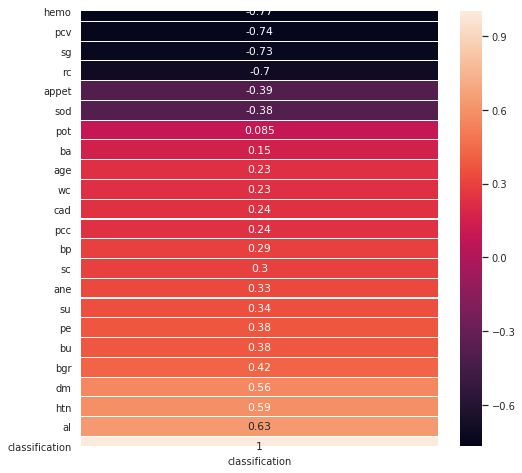

In [5]:
corr_matrix=full_data.corr()['classification'].sort_values().to_frame()
plt.figure(figsize=(8,8))
plt.rcParams["axes.labelsize"] = 15
sns.set(font_scale=0.9)
sns.heatmap(corr_matrix, annot = True ,linewidths=.1)
plt.show()

We have chosen **10 features** to use in our final model. Initially there were 24 features. We chose these features based on their **pearson's correlation coefficient** (highest positive and negative coefficients).


The features we have chosen, along with their corellations are:

> Albumin (al) :    **0.63**


> Specific Gravity (sg) :    **-0.73**



> Hemoglobin (hemo) : **-0.77**


> Packed cell Volume (pcv) : **-0.74**


> Red Blood Cell Count (rc) : **-0.7**


> Hypertension (htn) : **0.59**


> Diabetes Mellitus (dm) : **0.56**



> Blood Glucose Random (bgr) : **0.42**


> Blood Urea (bu) : **0.38**


> Appetite (appet) : **-0.39**























The first 7 have been chosen as compulsory features to be entered, when we predict the result.
As we are implementing the model on a web server, the user must enter the first seven features specified above.

The last 3 features are optional features. If they are not entered, a reasonable value will be used based on the compulsory features.
We will train 3 models with the optional features as targets, and the 7 compulsory features as input





In [0]:
#Removing id column and splitting fataset into features and target
X = full_data.drop(['classification'],axis = 1,inplace=False)
y = full_data[['classification']]

#Splitting dataset into Train set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state =3)

#Categorical attributes
cat_attr = []

#Numerical attributes
num_attr= []

for column,dtype in zip(X_train.columns,X_train.dtypes.values):
    if dtype == 'O':
        cat_attr.append(column)
    else:
        num_attr.append(column)


num_pipeline = Pipeline([('impute',SimpleImputer(strategy = 'median')),('normalize',StandardScaler())])

transformer = ColumnTransformer([('num',num_pipeline,num_attr),('cat','passthrough',cat_attr)])

#Prepared features
X_prepared = transformer.fit_transform(X_train)




In [7]:
svc = SVC(kernel='linear')
svc.fit(X_prepared,y_train)
y_pred_svc = svc.predict(transformer.transform(X_test))

print(accuracy_score(y_test,y_pred_svc))

0.9666666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


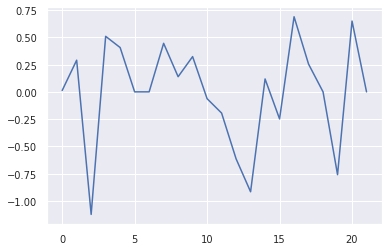

In [8]:
print(plt.plot(svc.coef_.ravel()))

In [9]:
sgd = SGDClassifier()
sgd.fit(X_prepared,y_train)
y_pred_sgd = sgd.predict(transformer.transform(X_test))

print(accuracy_score(y_test,y_pred_sgd))

0.975


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


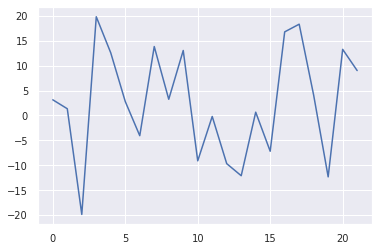

In [10]:
plt.plot(sgd.coef_.ravel())

In [11]:
def takeSecond(elem):
    return elem[1]

print(sorted(list(zip(X.columns,svc.coef_.ravel())),key = takeSecond))

[('sg', -1.1257475886294772), ('pcv', -0.9177597820435132), ('appet', -0.7607237161328927), ('hemo', -0.6152133248288372), ('rc', -0.2488636604373014), ('pot', -0.19493976345360237), ('sod', -0.06283069418991809), ('ba', -5.551115123125783e-17), ('pcc', -2.7755575615628914e-17), ('ane', -6.938893903907228e-18), ('cad', 0.0), ('age', 0.0124446821784375), ('wc', 0.11852096987074523), ('bu', 0.1391319684746033), ('dm', 0.25488968013062424), ('bp', 0.29089357270679994), ('sc', 0.3237933052399764), ('su', 0.4070226458205725), ('bgr', 0.44589072490206705), ('al', 0.5101828457422665), ('pe', 0.6501384900900898), ('htn', 0.6899347567458085)]


In [12]:
print(sorted(list(zip(X.columns,sgd.coef_.ravel())),key = takeSecond))

[('sg', -19.857664872557958), ('appet', -12.321266522068557), ('pcv', -12.091872214527616), ('hemo', -9.667619395263841), ('sod', -9.103989438139052), ('rc', -7.178782860337523), ('ba', -4.056529850220652), ('pot', -0.19589683572528216), ('wc', 0.6617775051749886), ('bp', 1.353273055652494), ('pcc', 2.8071303243741363), ('age', 3.1454760901377266), ('bu', 3.2536262169970764), ('cad', 4.0571456388933385), ('ane', 9.014040445696748), ('su', 12.561640274382809), ('sc', 13.04321159997479), ('pe', 13.273312988646415), ('bgr', 13.834547402742091), ('htn', 16.780853008174024), ('dm', 18.32330231749986), ('al', 19.816953268500573)]


Considering the coefficients assigned to each of the attributes by the linear models: the linear kernel SVC and the SGDClassifier, the highest coefficients in the above linear models have been given to : sg, hemo, pcv, al, htn, dm, appet, along with bgr, bu and rc.
Thus this is congruent to the results obtained using the correlation matrix.

In [0]:
X = X[['sg', 'hemo', 'pcv', 'al','rc','bgr','bu', 'htn', 'dm', 'appet']]

num_attr_new = ['sg','hemo','pcv','al','rc','bgr','bu']
cat_attr_new = ['htn','dm','appet']

#Splitting dataset into Train set and Test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = random.randint(1,1000))

num_pipeline = Pipeline([('impute',SimpleImputer(strategy = 'median')),('normalize',StandardScaler())])

transformer = ColumnTransformer([('num',num_pipeline,num_attr_new),('cat','passthrough',cat_attr_new)])

#Prepared features
X_prepared = transformer.fit_transform(X_train)

In [14]:
svc_cv = SVC(kernel='linear')

scores = cross_val_score(svc_cv, X_prepared, y_train,scoring='accuracy',cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
print(scores)

[0.98130841 0.99065421 0.99056604]


In [16]:
svc_final = SVC(kernel='linear')
svc_final.fit(X_prepared,y_train)
y_pred = svc_final.predict(transformer.transform(X_test))

print(accuracy_score(y_test,y_pred))

0.9875


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
